#**Git-Hub URL**

In [ ]:
https://github.com/aamemara/gan-getting-started.git

#**Imports**

In [9]:
from google.colab import drive
import tensorflow as tf
from tensorflow.keras import layers, Model, losses, optimizers
from PIL import Image
import os
from tqdm import tqdm
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#**EDA**

In [2]:
# Mount drive to load files
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_tensor_images_from_directory(directory):
    images = []
    for filename in os.listdir(directory):
        image_path = os.path.join(directory, filename)
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.cast(image, tf.float32) / 255.0
        images.append(image)
    return images

drive_path = "drive/MyDrive/Colab Notebooks/University of Colorado Boulder:  Introduction to Deep Learning/"
os.listdir(drive_path+"gan-getting-started")

# Load style images
style_images_directory = drive_path+"gan-getting-started/monet_jpg"
style_tensor_images = load_tensor_images_from_directory(style_images_directory)

# Load content images
content_images_directory = drive_path+"gan-getting-started/photo_jpg"
content_tensor_images = load_tensor_images_from_directory(content_images_directory)

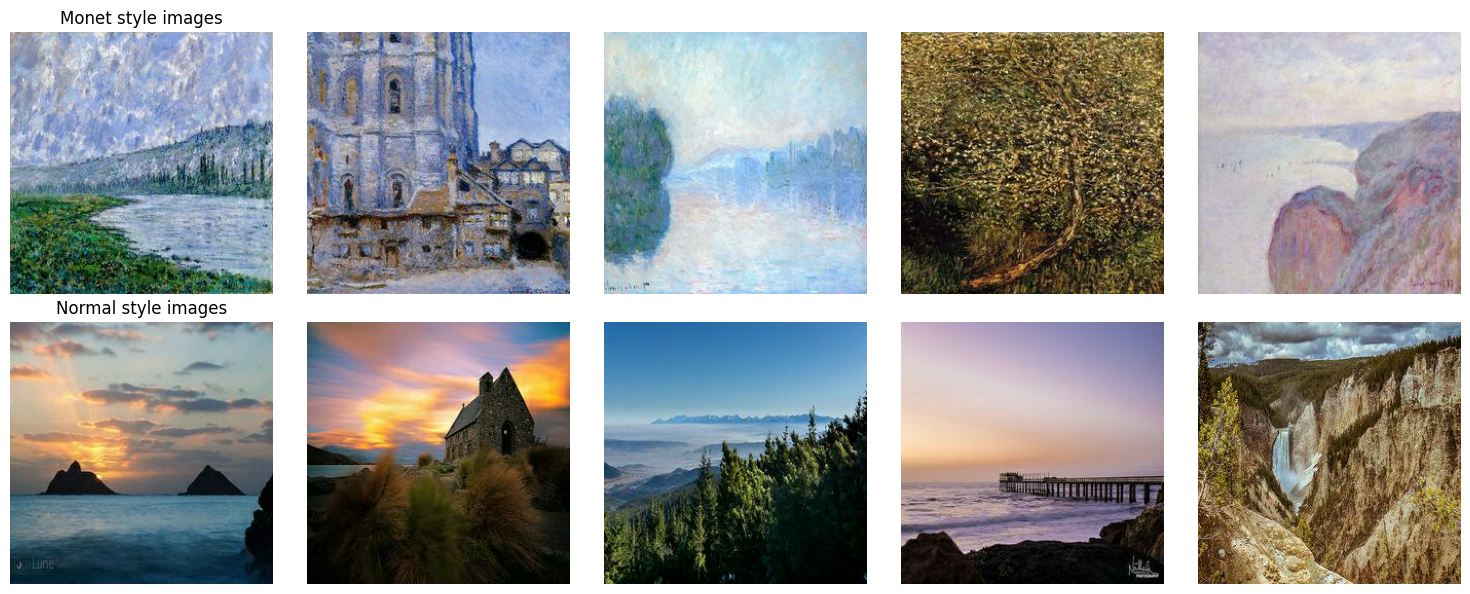

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes[0, 0].set_title("Monet style images")  # Set the title for the Monet style images
axes[1, 0].set_title("Normal style images")  # Set the title for the normal style images

# Loop through first 5 Monet style images and display them in subplots
for i in range(5):
    ax = axes[0, i]  # Get the axis for the current subplot
    image = style_tensor_images[i]
    ax.imshow(image.numpy())  # Display the image
    ax.axis('off')  # Turn off axis labels
# Loop through first 5 normal style images and display them in subplots
for i in range(5):
    ax = axes[1, i]  # Get the axis for the current subplot
    image = content_tensor_images[i]
    ax.imshow(image.numpy())  # Display the image
    ax.axis('off')  # Turn off axis labels

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

#**Model building and training**


In [6]:
# Generator Architecture for CycleGAN
def build_generator(input_shape, name=None):
    inputs = layers.Input(shape=input_shape)

    # Downsampling
    x = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', activation='relu')(inputs)
    skip_connections = [x]
    for i in range(7):
        x = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
        skip_connections.append(x)

    # Residual blocks
    #for _ in range(6):
    #    x = residual_block(x, 128)

    # Upsampling
    for i in range(7):
        x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
        x = layers.concatenate([x, skip_connections[-(i+2)]])
    outputs = layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='tanh')(x)

    generator_model = Model(inputs, outputs, name=name)
    return generator_model

# Discriminator Architecture for CycleGAN
def build_discriminator(input_shape, name=None):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
    #x = layers.Flatten()(x)
    #x = layers.Dense(256, activation='relu')(x)
    #outputs = layers.Dense(1, activation='sigmoid')(x)
    outputs = layers.Conv2D(1, (4, 4), padding='same')(x)

    discriminator_model = Model(inputs, outputs, name=name)
    return discriminator_model

# Residual Block
def residual_block(x, filters):
    y = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Conv2D(filters, (3, 3), padding='same')(y)
    y = layers.BatchNormalization()(y)
    return layers.add([x, y])

def generator_loss(fake_output, reconstructed_input, target_input, generated_images, LAMDBA=10):
    # Adversarial loss
    adversarial_loss = tf.reduce_mean(tf.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output))
    # Cycle-consistency loss
    cycle_consistency_loss = tf.reduce_mean(tf.abs(reconstructed_input - target_input))
    # Identity loss
    identity_loss = tf.reduce_mean(tf.abs(generated_images - target_input))
    # Total generator loss
    total_loss = adversarial_loss + LAMDBA * cycle_consistency_loss + 0.5 * LAMDBA * identity_loss
    return total_loss

def discriminator_loss(real_output, fake_output):
    # Loss for real images
    real_loss = tf.reduce_mean(tf.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output))
    # Loss for fake images
    fake_loss = tf.reduce_mean(tf.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output))
    # Total discriminator loss
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, 0.5), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, 0.5), tf.float32))
    total_accuracy = 0.5 * (real_accuracy + fake_accuracy)
    return total_accuracy

In [7]:
input_shape = (256,256,3)
generator_style_to_normal = build_generator(input_shape)
generator_normal_to_style = build_generator(input_shape)
discriminator_style = build_discriminator(input_shape)
discriminator_normal = build_discriminator(input_shape)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [8]:
@tf.function
def train_step(real_style_images, real_normal_images,
               generator_style_to_normal, generator_normal_to_style,
               discriminator_style, discriminator_normal,
               generator_optimizer, discriminator_optimizer):
    with tf.GradientTape(persistent=True) as tape:
        # Forward pass through generators
        fake_normal_images = generator_style_to_normal(real_style_images)
        fake_style_images = generator_normal_to_style(real_normal_images)

        # Cycle consistency: reconstruct images
        reconstructed_style_images = generator_normal_to_style(generator_style_to_normal(real_style_images))
        reconstructed_normal_images = generator_style_to_normal(generator_normal_to_style(real_normal_images))

        # Forward pass through discriminators
        real_style_output = discriminator_style(real_style_images)
        fake_style_output = discriminator_style(fake_style_images)
        real_normal_output = discriminator_normal(real_normal_images)
        fake_normal_output = discriminator_normal(fake_normal_images)

        # Compute losses
        gen_style_loss = generator_loss(fake_style_output, reconstructed_style_images, real_style_images, fake_normal_images)
        gen_normal_loss = generator_loss(fake_normal_output, reconstructed_normal_images, real_normal_images, fake_style_images)
        total_gen_loss = gen_style_loss + gen_normal_loss
        disc_style_loss = discriminator_loss(real_style_output, fake_style_output)
        disc_normal_loss = discriminator_loss(real_normal_output, fake_normal_output)
        total_disc_loss = disc_style_loss + disc_normal_loss

        # Compute discriminator accuracy
        disc_accuracy = discriminator_accuracy(real_style_output, fake_style_output)

    # Compute gradients and update parameters
    generator_gradients = tape.gradient(total_gen_loss, generator_style_to_normal.trainable_variables + generator_normal_to_style.trainable_variables)
    discriminator_gradients = tape.gradient(total_disc_loss, discriminator_style.trainable_variables + discriminator_normal.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator_style_to_normal.trainable_variables + generator_normal_to_style.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator_style.trainable_variables + discriminator_normal.trainable_variables))
    #tf.print("Discriminator Loss:", total_disc_loss, "Generator Loss:", total_gen_loss, "Discriminator Accuracy:", disc_accuracy)

In [9]:
if not os.path.exists(drive_path+"gan-getting-started/generator_normal_to_style.h5"):
    epochs = 10
    batch_size = 15
    num_batches = len(style_tensor_images) // batch_size
    for epoch in range(epochs):
        print(f'Epoch {epoch+1} of {epochs}')
        for i in tqdm(range(num_batches)):
            real_style_images = tf.stack(style_tensor_images[(i)*batch_size:(i+1)*batch_size], axis=0)
            real_normal_images = tf.stack(content_tensor_images[(epoch*num_batches+i)*batch_size:(epoch*num_batches+i+1)*batch_size], axis=0)
            train_step(real_style_images, real_normal_images,
                       generator_style_to_normal, generator_normal_to_style,
                       discriminator_style, discriminator_normal,
                       generator_optimizer, discriminator_optimizer)
        # Print progress
        #print(f'Discriminator Loss: {total_disc_loss}, Generator Loss: {total_gen_loss}, Discriminator Accuracy: {disc_accuracy}')
    generator_style_to_normal.save_weights(drive_path+"gan-getting-started/generator_style_to_normal.h5")
    generator_normal_to_style.save_weights(drive_path+"gan-getting-started/generator_normal_to_style.h5")
    discriminator_style.save_weights(drive_path+"gan-getting-started/discriminator_style.h5")
    discriminator_normal.save_weights(drive_path+"gan-getting-started/discriminator_normal.h5")
else:
    generator_style_to_normal.load_weights(drive_path+"gan-getting-started/generator_style_to_normal.h5")
    generator_normal_to_style.load_weights(drive_path+"gan-getting-started/generator_normal_to_style.h5")
    discriminator_style.load_weights(drive_path+"gan-getting-started/discriminator_style.h5")
    discriminator_normal.load_weights(drive_path+"gan-getting-started/discriminator_normal.h5")

#**Generating Output**

In [16]:
output_dir = drive_path+"gan-getting-started/images/"
os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist
for i,content_tensor_image in tqdm(enumerate(content_tensor_images)):
  #generated_images = generator_model(tf.stack(content_tensor_images,axis=0))
  generated_image = generator_normal_to_style(tf.expand_dims(content_tensor_image, axis=0))
  generated_image_pil = tf.keras.preprocessing.image.array_to_img(generated_image[0])
  # Save the PIL image as a JPEG file
  output_path = os.path.join(output_dir, "generated_image_{}.jpg".format(i))
  generated_image_pil.save(output_path)

7038it [33:19,  3.52it/s]


In [7]:
output_dir = drive_path+"gan-getting-started/images/"


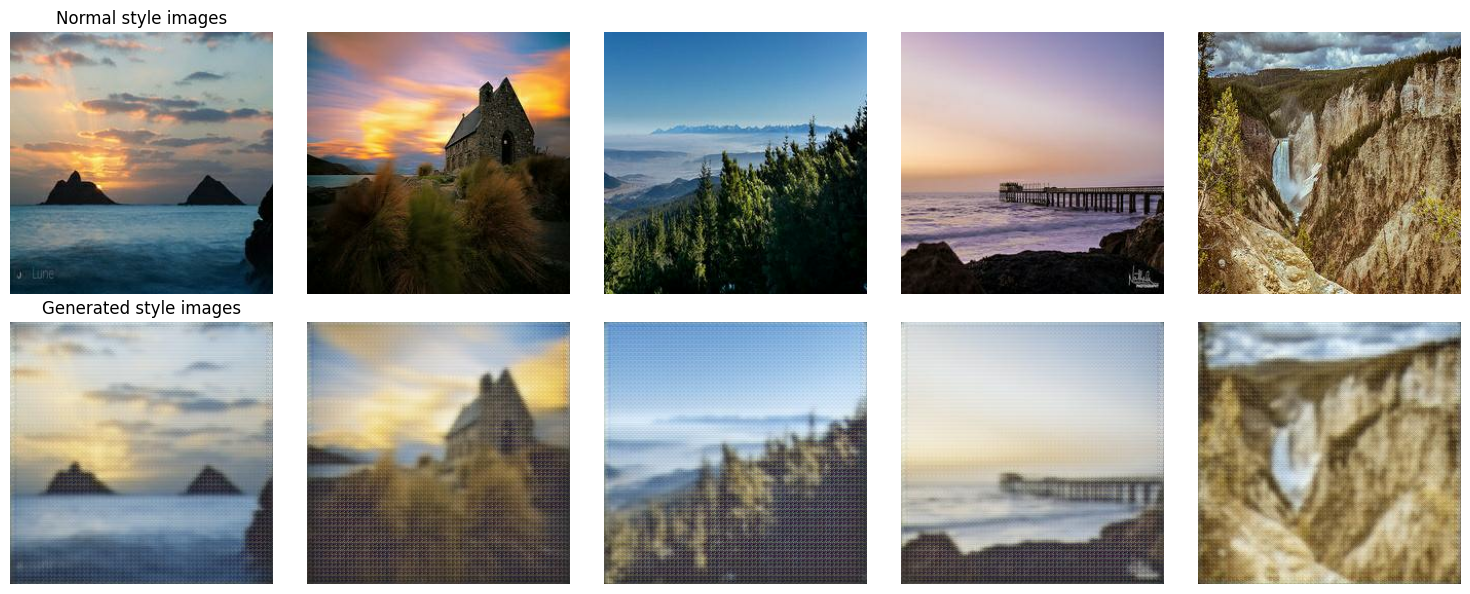

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes[0, 0].set_title("Normal style images")  # Set the title for the Monet style images
axes[1, 0].set_title("Generated style images")  # Set the title for the normal style images

# Loop through first 5 normal style images and display them in subplots
for i in range(5):
    ax = axes[0, i]  # Get the axis for the current subplot
    image = content_tensor_images[i]
    ax.imshow(image.numpy())  # Display the image
    ax.axis('off')  # Turn off axis labels
# Loop through first 5 generated style images and display them in subplots
for i in range(5):
    ax = axes[1, i]  # Get the axis for the current subplot
    image = mpimg.imread(output_dir+"generated_image_{}.jpg".format(i))
    ax.imshow(image)  # Display the image
    ax.axis('off')  # Turn off axis labels

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
shutil.make_archive(drive_path+"gan-getting-started/images", 'zip', output_dir)